In [1]:
#import packages 📦 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image 
import skimage.io
import skimage.transform
from PIL import Image
import numpy as np
import seaborn as sns
import math
import copy
%matplotlib inline

In [2]:
#import more packages 📦 
import keras.backend as K
from keras import optimizers
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import decode_predictions
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.models import Sequential
from sklearn.metrics import confusion_matrix

In [3]:
K.clear_session()

In [4]:
#Vgg-face takes data in shape (224,224,3), the RGB channel is on the last axis,
K.set_image_data_format( 'channels_last' ) 
nrow = 224
ncol = 224

In [5]:
#load VGG Face
vggface = VGGFace(model='vgg16') 
vggface.summary()

Metal device set to: Apple M2


2022-12-05 22:19:31.465592: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-05 22:19:31.465668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [6]:
#custom parameters
# 3 Names, 3 classes
nb_class = 4
hidden_dim = 512

vgg_notop = VGGFace(include_top=False, input_shape=(224, 224, 3))
for layer in vgg_notop.layers:
    layer.trainable = False

last_layer = vgg_notop.get_layer('pool5').output

x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)

custom_vgg_model = Model(vgg_notop.input, out)
custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [7]:
#training data set
batch_size = 8

train_data_dir = '/Users/cebastiansantiago/Downloads/masked/train'
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='sparse')

Found 425 images belonging to 4 classes.


In [8]:
#test data set
test_data_dir = '/Users/cebastiansantiago/Downloads/masked/test'
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                 )
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size, shuffle = False,
                        class_mode='sparse') 

Found 258 images belonging to 4 classes.


In [9]:
#display image function
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

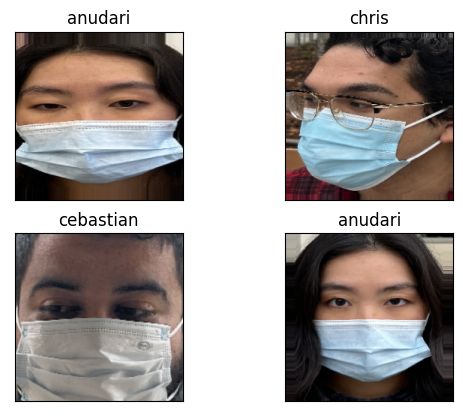

In [10]:

textFileNames = ['anudari' , 'cebastian','chris','michael']




batch_shape = (batch_size,custom_vgg_model.input_shape[1] , 
               custom_vgg_model.input_shape[2], 
               custom_vgg_model.input_shape[3])
X = np.zeros(batch_shape)
y = np.zeros(batch_size)

X,y = train_generator.next()
nplot = 4        
for i in range(nplot):    
    plt.subplot(2,int(nplot/2),i+1)
    disp_image(X[i,:,:,:])
    title = (textFileNames[int(y[i])])
    plt.title(title)

In [11]:
#train the model
custom_vgg_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                         metrics=['accuracy'])

/Users/cebastiansantiago/Downloads/ENTER/envs/tflabs/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
steps_per_epoch =  train_generator.n // batch_size
validation_steps =  test_generator.n // batch_size

nepochs = 40

history = custom_vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Epoch 1/40


/var/folders/kx/3v10kwc567xffx4skmgm48mw0000gn/T/ipykernel_2054/3076710957.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = custom_vgg_model.fit_generator(
2022-12-05 22:19:40.334317: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-05 22:19:40.644254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - ETA: 0s - loss: 1.3779 - accuracy: 0.3141

2022-12-05 22:19:46.231880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


53/53 [==============================] - 9s 163ms/step - loss: 1.3779 - accuracy: 0.3141 - val_loss: 1.3648 - val_accuracy: 0.4805
Epoch 2/40
53/53 [==============================] - 8s 155ms/step - loss: 1.3509 - accuracy: 0.5564 - val_loss: 1.3387 - val_accuracy: 0.6055
Epoch 3/40
53/53 [==============================] - 8s 157ms/step - loss: 1.3246 - accuracy: 0.6187 - val_loss: 1.3137 - val_accuracy: 0.6445
Epoch 4/40
53/53 [==============================] - 8s 156ms/step - loss: 1.3022 - accuracy: 0.6763 - val_loss: 1.2898 - val_accuracy: 0.7148
Epoch 5/40
53/53 [==============================] - 8s 158ms/step - loss: 1.2717 - accuracy: 0.7458 - val_loss: 1.2629 - val_accuracy: 0.7461
Epoch 6/40
53/53 [==============================] - 8s 157ms/step - loss: 1.2456 - accuracy: 0.7770 - val_loss: 1.2389 - val_accuracy: 0.7734
Epoch 7/40
53/53 [==============================] - 8s 156ms/step - loss: 1.2177 - accuracy: 0.7866 - val_loss: 1.2105 - val_accuracy: 0.7891
Epoch 8/40
53/53 

In [13]:
#Define functions to plot accuracy and loss
def plotAccuracy(history):

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 
    
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 

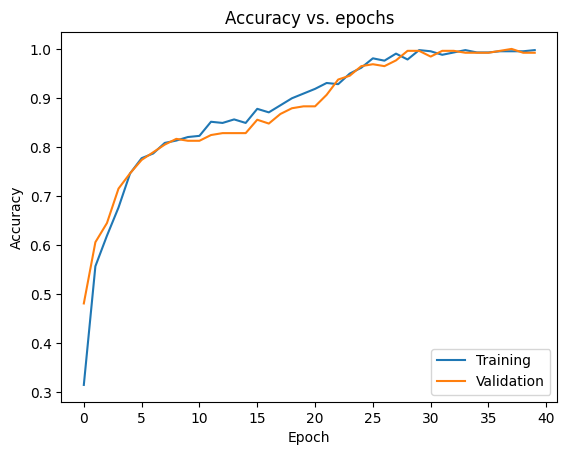

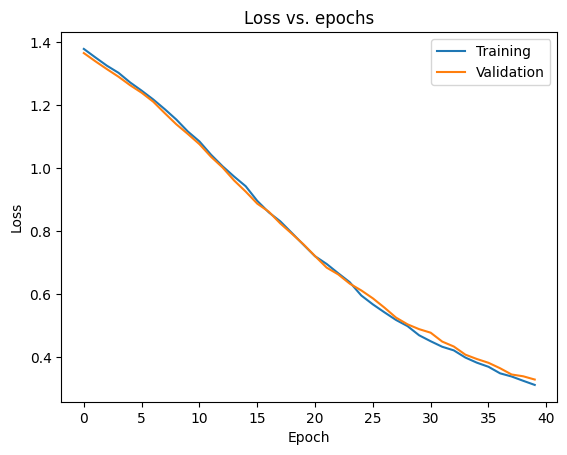

In [14]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(history)
plotLoss(history)

 1/33 [..............................] - ETA: 6s

2022-12-05 22:25:13.729791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 3s 98ms/step


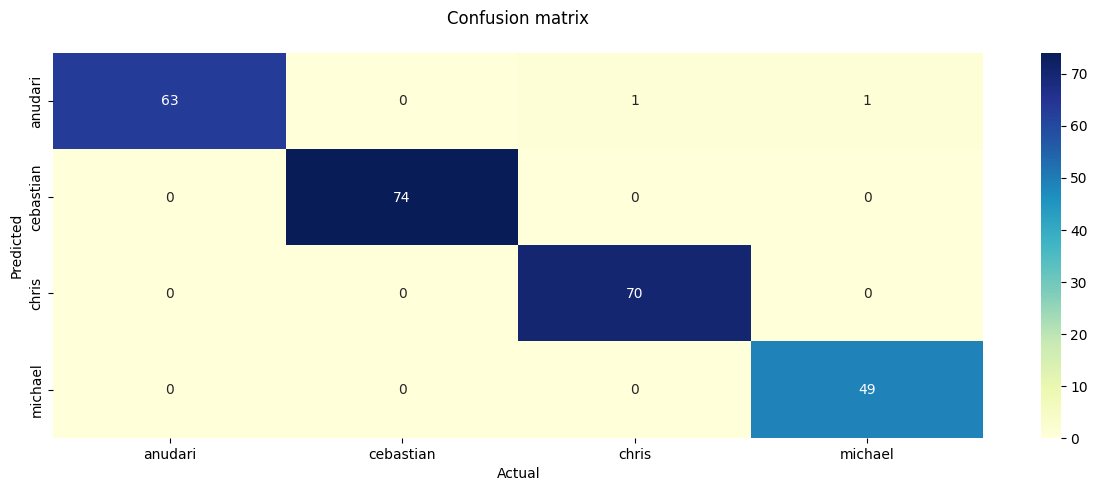

In [15]:
names = ['anudari' , 'cebastian','chris','michael']
#Confusion Matrix 
plt.figure(figsize=(15, 5))

#Predict test images
Y_pred = custom_vgg_model.predict(test_generator)

#Get corresponding predicted label
y_pred = np.argmax(Y_pred, axis=1)

cf = confusion_matrix(test_generator.classes, y_pred)

df_cm = pd.DataFrame(cf, index=names, columns=names)

sns.heatmap(df_cm, annot= True,fmt="d",cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title("Confusion matrix\n")
plt.show()

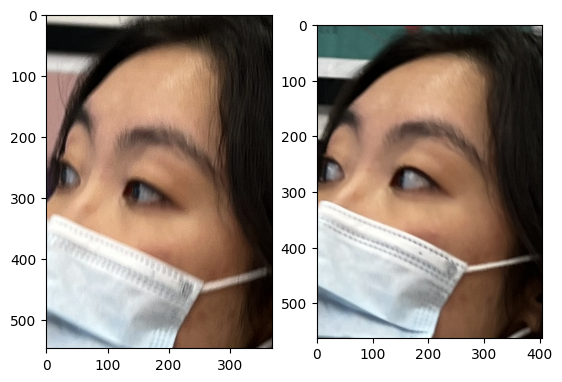

In [44]:
#display misclassifiedimages
from matplotlib import image as mpimg

#Reference to this part of code -> https://stackoverflow.com/questions/39300880/how-to-find-wrong-prediction-cases-in-test-set-cnns-using-keras
fnames = test_generator.filenames ## fnames is all the filenames/samples used in testing
errors = np.where(y_pred != test_generator.classes)[0] ## misclassifications done on the test data where y_pred is the predicted values
f, axarr = plt.subplots(1,2)
j = 0

for i in errors:
    names = '/Users/cebastiansantiago/Downloads/masked/train/' + fnames[i]
    image = mpimg.imread(names)
    axarr[j].imshow(image)
    j+=1

1/1 [==============================] - 0s 15ms/step


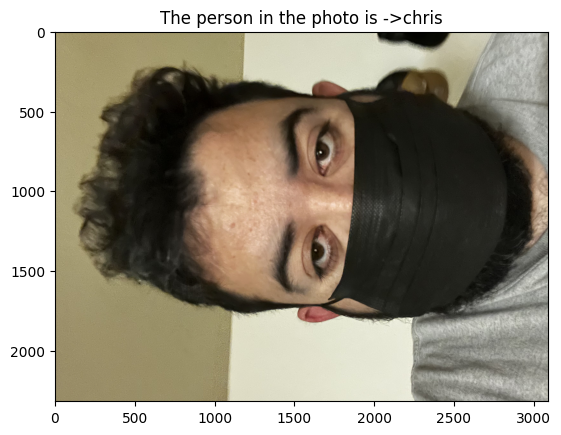

In [50]:
from tensorflow.keras.utils import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input
from matplotlib import image as mpimg
names = ['anudari' , 'cebastian','chris','michael']
# test image for me(Cebastian) load the image
my_images = load_img('/Users/cebastiansantiago/Downloads/FaceMaskDetection/train/cebastian/IMG_0530.jpg', target_size=(224, 224))

#preprocess the image
my_image = img_to_array(my_images)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

#make the prediction
prediction = custom_vgg_model.predict(my_image)

#print the photo
pred = "The person in the photo is ->" + names[np.argmax(prediction[0])]
plt.title(pred)
image = mpimg.imread("/Users/cebastiansantiago/Downloads/FaceMaskDetection/train/cebastian/IMG_0530.jpg")
plt.imshow(image)


1/1 [==============================] - 0s 10ms/step


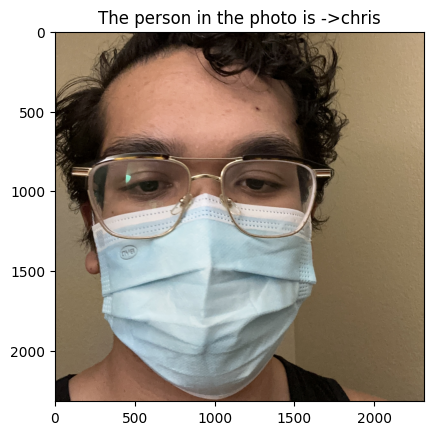

In [51]:
# test image for chris load the image
my_image = load_img('/Users/cebastiansantiago/Downloads/FaceMaskDetection/train/chris/IMG_0371.jpg', target_size=(224, 224))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

#make the prediction
prediction = custom_vgg_model.predict(my_image)


#print the photo
pred = "The person in the photo is ->" + names[np.argmax(prediction[0])]
plt.title(pred)
image = mpimg.imread("/Users/cebastiansantiago/Downloads/FaceMaskDetection/train/chris/IMG_0371.jpg")
plt.imshow(image)






1/1 [==============================] - 0s 9ms/step


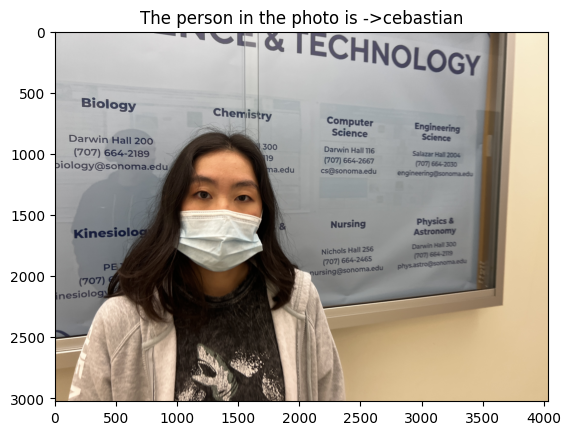

In [52]:
# test image for anudari load the image
my_image = load_img('/Users/cebastiansantiago/Downloads/FaceMaskDetection/train/anudari/IMG_6577.JPG', target_size=(224, 224))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

#make the prediction
prediction = custom_vgg_model.predict(my_image)



#print the photo
pred = "The person in the photo is ->" + names[np.argmax(prediction[0])]
plt.title(pred)
image = mpimg.imread("/Users/cebastiansantiago/Downloads/FaceMaskDetection/train/anudari/IMG_6578.JPG")
plt.imshow(image)





1/1 [==============================] - 0s 9ms/step


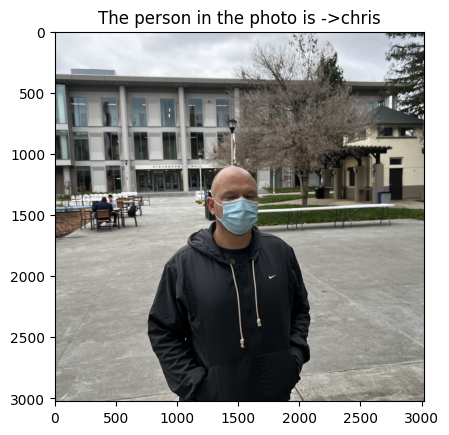

In [53]:
# test image for michael load the image
my_image = load_img('/Users/cebastiansantiago/Downloads/FaceMaskDetection/train/michael/IMG_6086.JPG', target_size=(224, 224))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
my_image = preprocess_input(my_image)

#make the prediction
prediction = custom_vgg_model.predict(my_image)



#print the photo
pred = "The person in the photo is ->" + names[np.argmax(prediction[0])]
plt.title(pred)
image = mpimg.imread("/Users/cebastiansantiago/Downloads/FaceMaskDetection/train/michael/IMG_6086.JPG")
plt.imshow(image)




1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


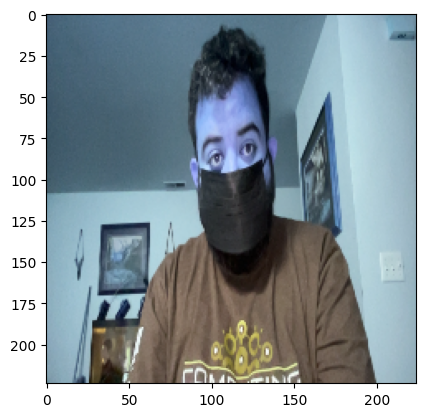

In [69]:
#chris model but i edited 
import cv2

predictionLabel = ''
boxColor = (0,0,0)

network = cv2.dnn.readNetFromCaffe("/Users/cebastiansantiago/downloads/deploy.prototxt", "/Users/cebastiansantiago/downloads/res10_300x300_ssd_iter_140000_fp16.caffemodel")

video = cv2.VideoCapture(0)

if (video.isOpened() == False):
    print("Web Camera not detected")
while (True):
    ret, frame = video.read()
    if ret == True:
        ### DETECT FACE LOCATION USING DNN
        dnn_label = ''
        dnn_boxColor = (0,0,0)

        dnn_image = cv2.resize(frame, (582,448))

        (height, width) = dnn_image.shape[:2]
        blob = cv2.dnn.blobFromImage(dnn_image, scalefactor=1.0, size=(300, 300), mean=(104.0, 117.0, 123.0))
        network.setInput(blob)
        detections = network.forward()
        

       
        my_image = cv2.resize(dnn_image, (224,224))
        plt.imshow(my_image)
        my_image = img_to_array(my_image)
        my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
        my_image = preprocess_input(my_image)
        
        #make the prediction
        
        dnn_label = 'Masked - '
        #make the prediction
        prediction = custom_vgg_model.predict(my_image)
        dnn_boxColor = (255,0,0)
    

        dnn_label = dnn_label + names[np.argmax(prediction[0])]
 

        for i in range(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > 0.7:
                box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
                left = int(box[0])
                top = int(box[1])
                right = int(box[2])
                bottom = int(box[3])

                cv2.rectangle(dnn_image, (left - 10, top - 50), (right + 10, bottom + 50), dnn_boxColor, 2)
                cv2.rectangle(dnn_image, (left - 11, top - 49), (right + 11, top -24), dnn_boxColor, cv2.FILLED)
                font = cv2.FONT_HERSHEY_DUPLEX
                cv2.putText(dnn_image, dnn_label, (left - 6, top - 36), font, 0.5, (255, 255, 255), 1)

        cv2.imshow("DNN", dnn_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

video.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cebastian


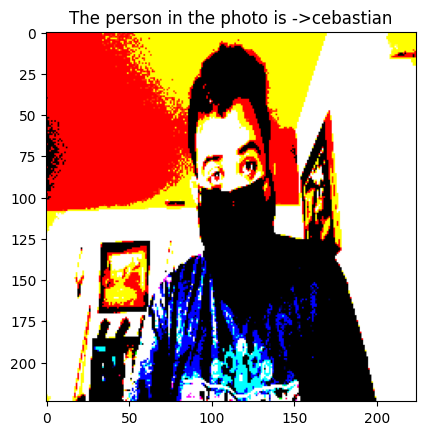

In [70]:
#make the prediction
prediction = custom_vgg_model.predict(my_image)

print(names[np.argmax(prediction[0])])

#print the photo
pred = "The person in the photo is ->" + names[np.argmax(prediction[0])]
plt.title(pred)
plt.imshow(my_image[0])

In [ ]:
# Save the entire model as a SavedModel.
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
custom_vgg_model.save('face_model.h5')